# Princess Sakura Main #

## Imports ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim

In [36]:
# Read the CSV file
first_blooms = pd.read_csv("data/kaggle-cherry-blossom/sakura_first_bloom_dates_with_lat_long.csv", parse_dates=[str(x) for x in range(1953, 2024)])

In [37]:
first_blooms.dropna(subset=["Latitude"], inplace=True)
first_blooms

,Site Name,Latitude,Longitude,Currently Being Observed,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,45.415811,141.673031,True,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,43.941029,141.636817,False,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,43.762750,142.357926,True,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,44.019918,144.254127,True,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaT,NaT,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,43.061936,141.354292,True,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaT,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Miyakojima,24.805465,125.281130,True,NaT,NaT,NaT,NaT,NaT,NaT,...,2016-02-04,2017-01-30,2018-01-23,2019-01-07,2020-02-07,2021-01-16,2022-01-19,2023-01-15,1 17,Taiwan cherry (Prunus campanulata)
97,Kumejima,26.341139,126.789053,False,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-,Taiwan cherry (Prunus campanulata)
98,Naha,26.212235,127.679145,True,NaT,NaT,NaT,NaT,NaT,NaT,...,2016-01-21,2017-01-14,2018-01-10,2019-01-10,2020-01-06,2021-01-04,2022-01-11,2023-01-07,1 16,Taiwan cherry (Prunus campanulata)
99,Nago,26.591960,127.977476,False,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,-,Taiwan cherry (Prunus campanulata)


In [29]:
# weather_df["time"] = pd.to_datetime(weather_df["time"])

In [33]:
weather_df = pd.read_csv("data/kaggle-cherry-blossom/weather_data_from_1952.csv", parse_dates=["time"])

In [7]:
def get_lat_long(city):
    geolocator = Nominatim(user_agent="my-app")
    location = geolocator.geocode(city)
    if location is None:
        return None, None
    return location.latitude, location.longitude

In [8]:
def find_weather_data(
    site_name, latitude, longitude, start, end, replace_snow_prcp_nans=True
):
    """Get the daily weather data for the site nearest to the given site name.

    Parameters
    ----------
    site_name : str
        The name of the site.
    start : datetime
        The start date of the weather data.
    end : datetime
        The end date of the weather data.
    replace_snow_prcp_nans : bool
        If True, replace the NaNs in snow and prcp the weather data with 0.

    Returns
    -------
    data : pandas.DataFrame
        The daily weather data for the site nearest to the given site name.
    """

    # Fetch the nearest station
    stations = Stations()
    nearest_station = stations.nearby(latitude, longitude).fetch(1)

    # Fetch the daily weather data
    data = Daily(nearest_station.index[0], start, end)
    data = data.fetch()
    data.reset_index(inplace=True)
    data["Site Name"] = site_name
    data = data.reindex(
        columns=["Site Name"]
        + list(data.columns.drop(["Site Name"]))
    )
    
    if replace_snow_prcp_nans:
        # Replace the NaNs in snow and prcp with 0
        data["snow"] = data["snow"].fillna(0)
        data["prcp"] = data["prcp"].fillna(0)

    return data

In [84]:
weather_df = pd.DataFrame(columns=["Site Name", "time", "tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun"])

# i = 0 
for site, lat, long in zip(first_blooms["Site Name"], first_blooms["Latitude"], first_blooms["Longitude"]):
    # if i >= 50:
    #     break
    start = datetime(1952, 1, 1)
    end = datetime(2023, 12, 9)
    data = find_weather_data(site, lat, long, start, end)
    weather_df = pd.concat([weather_df, data], ignore_index=True)
    # i += 1

weather_df

,Site Name,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,Wakkanai,1952-01-01,NaN,-3.6,1.5,17.1,0.0,NaN,NaN,NaN,NaN,NaN
1,Wakkanai,1952-01-02,NaN,-4.7,-2.7,2.1,0.0,NaN,NaN,NaN,NaN,NaN
2,Wakkanai,1952-01-03,NaN,-6.2,-0.6,0.6,0.0,NaN,NaN,NaN,NaN,NaN
3,Wakkanai,1952-01-04,NaN,-6.3,-0.3,1.9,0.0,NaN,NaN,NaN,NaN,NaN
4,Wakkanai,1952-01-05,NaN,-5.1,-2.3,12.7,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2094496,Nago,2023-12-05,20.8,19.2,22.5,2.6,0.0,321.0,29.1,NaN,1012.5,NaN
2094497,Nago,2023-12-06,19.1,17.0,21.6,5.1,0.0,13.0,14.1,NaN,1015.3,NaN
2094498,Nago,2023-12-07,17.8,15.4,19.7,1.4,0.0,5.0,22.1,NaN,1018.1,NaN
2094499,Nago,2023-12-08,18.1,15.4,22.0,0.0,0.0,65.0,12.9,NaN,1019.5,NaN


In [87]:
weather_df.to_csv("data/kaggle-cherry-blossom/weather_data_from_1952.csv", index=False)

In [86]:
for site in first_blooms["Site Name"].unique():
    if site not in weather_df["Site Name"].unique():
        print(site)

Iriomote Island


In [85]:
len(weather_df["Site Name"].unique())

98

# Get Geolocation data for each site #

In [48]:
first_blooms['Latitude'], first_blooms['Longitude'] = zip(*first_blooms['Site Name'].apply(lambda site: get_lat_long(site + ", Japan")))

In [53]:
first_blooms = first_blooms.reindex(
    columns=["Site Name", "Latitude", "Longitude"]
    + list(first_blooms.columns.drop(["Site Name", "Latitude", "Longitude"]))
)

In [54]:
first_blooms.to_csv("data/kaggle-cherry-blossom/sakura_first_bloom_dates_with_lat_long.csv", index=False)

# Look at NaNs #

In [47]:
nan_counts_with_site[nan_counts_with_site["Site Name"] == "Tokyo Japan"]

,Site Name,0
51,Tokyo Japan,1


In [75]:
weather_nan_counts = weather_df.groupby("Site Name")["tavg"].apply(lambda x: x.isnull().sum())
weather_nan_counts_with_site = pd.DataFrame({"Site Name": weather_nan_counts.index, "NaN Count": weather_nan_counts.values})
print(weather_nan_counts_with_site)
sorted_weather_nan_counts_with_site = weather_nan_counts_with_site.sort_values(by="NaN Count")
print(sorted_weather_nan_counts_with_site)

          Site Name  NaN Count
0          Abashiri       3292
1            Aikawa         46
2             Akita          0
3            Aomori       6217
4         Asahikawa       3303
..              ...        ...
93        Yakushima         51
94         Yamagata          0
95         Yokohama       8394
96           Yonago       9009
97  Yonaguni Island          0

[98 rows x 2 columns]
          Site Name  NaN Count
97  Yonaguni Island          0
43         Miyazaki          0
59          Okayama          0
61            Osaka          0
63           Owashi          0
..              ...        ...
47           Nagano      13850
32          Kutchan      13864
84          Toyooka      13880
10        Fukushima      13880
48         Nagasaki      13880

[98 rows x 2 columns]


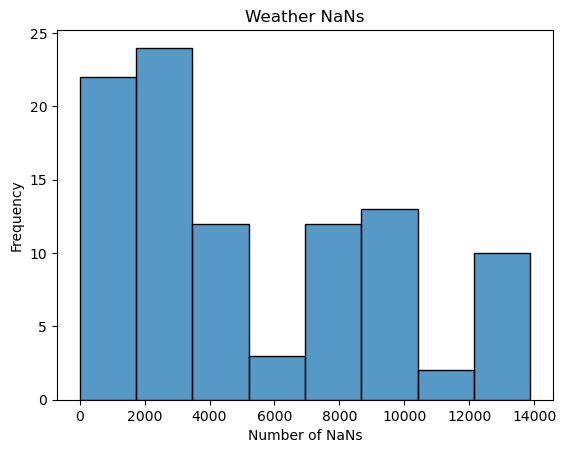

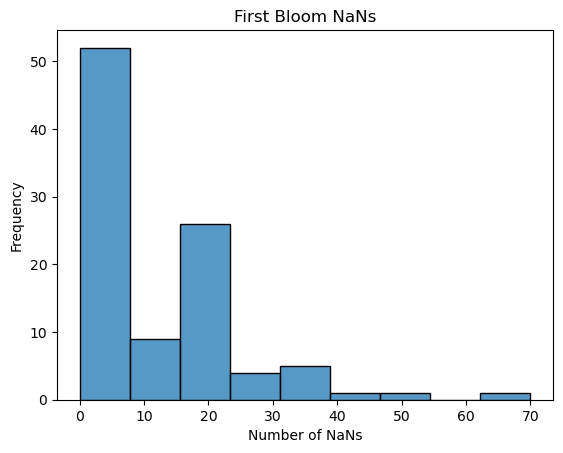

In [76]:
# Plot histogram of nan_counts_with_site
sns.histplot(weather_nan_counts_with_site["NaN Count"])
plt.title("Weather NaNs")
plt.xlabel("Number of NaNs")
plt.ylabel("Frequency")
plt.show()

# Plot histogram of first_bloom_nan_counts
sns.histplot(first_bloom_nan_counts[0])
plt.title("First Bloom NaNs")
plt.xlabel("Number of NaNs")
plt.ylabel("Frequency")
plt.show()


In [56]:
first_bloom_nan_counts[first_bloom_nan_counts[0] == 0]["Site Name"]

2       Asahikawa
6         Obihiro
9         Muroran
12       Hakodate
19          Akita
20        Morioka
23       Yamagata
24         Sendai
25      Fukushima
30        Niigata
31       Kanazawa
32         Toyama
33         Nagano
35     Utsunomiya
36          Fukui
39       Maebashi
40       Kumagaya
41           Mito
43           Gifu
44         Nagoya
46           Kofu
47         Choshi
48            Tsu
50       Shizuoka
51    Tokyo Japan
53       Yokohama
59         Matsue
61        Tottori
65          Kyoto
66         Hikone
67      Hiroshima
68        Okayama
69           Kobe
70          Osaka
72       Wakayama
75      Matsuyama
76      Takamatsu
79      Tokushima
80    Shimonoseki
82        Fukuoka
83           Saga
84           Oita
86       Nagasaki
87       Kumamoto
89      Kagoshima
Name: Site Name, dtype: object

In [78]:
weather_nan_counts_with_site[weather_nan_counts_with_site["NaN Count"] < 2000]["Site Name"]

1              Aikawa
2               Akita
14           Hakodate
35            Maizuru
43           Miyazaki
45            Morioka
50             Nagoya
59            Okayama
61              Osaka
63             Owashi
66              Saigo
68            Sapporo
73           Shizuoka
75             Takada
78        Tanegashima
81        Tokyo Japan
82            Tottori
83             Toyama
91           Wakayama
93          Yakushima
94           Yamagata
97    Yonaguni Island
Name: Site Name, dtype: object

In [86]:
weather_nan_counts

Site Name
Abashiri           3292
Aikawa               46
Akita                 0
Aomori             6217
Asahikawa          3303
                   ... 
Yakushima            51
Yamagata              0
Yokohama           8394
Yonago             9009
Yonaguni Island       0
Name: tavg, Length: 98, dtype: int64

In [90]:
weather_nan_counts_with_site[(weather_nan_counts_with_site["Site Name"] == "Kyoto") | (weather_nan_counts_with_site["Site Name"] == "Tokyo Japan")]

,Site Name,NaN Count
33,Kyoto,4072
81,Tokyo Japan,462


In [93]:
overlap_sites = set(
    first_bloom_nan_counts[first_bloom_nan_counts[0] == 0]["Site Name"]
).intersection(
    set(
        weather_nan_counts_with_site[weather_nan_counts_with_site["NaN Count"] < 5000][
            "Site Name"
        ]
    )
)
print(weather_nan_counts_with_site[weather_nan_counts_with_site["Site Name"].isin(overlap_sites)].sort_values(by="NaN Count"))
print(len(overlap_sites))

      Site Name  NaN Count
2         Akita          0
83       Toyama          0
82      Tottori          0
73     Shizuoka          0
61        Osaka          0
59      Okayama          0
91     Wakayama          0
94     Yamagata          0
50       Nagoya        437
81  Tokyo Japan        462
14     Hakodate        513
45      Morioka       1561
38    Matsuyama       3290
5        Choshi       3292
58         Oita       3294
4     Asahikawa       3303
34     Maebashi       3313
23    Kagoshima       3318
70  Shimonoseki       3331
29     Kumamoto       3334
27         Kofu       3353
36       Matsue       3766
57      Obihiro       3937
25         Kobe       3945
39         Mito       3980
46      Muroran       4072
33        Kyoto       4072
27


In [53]:
first_bloom_nan_counts = pd.concat([first_blooms["Site Name"], first_blooms[[str(x) for x in range(1953, 2024)]].isnull().sum(axis=1)], axis=1)
sorted_first_bloom_nan_counts_with_site = first_bloom_nan_counts.sort_values(by=0)
sorted_first_bloom_nan_counts_with_site[:50]

,Site Name,0
36,Fukui,0
25,Fukushima,0
84,Oita,0
51,Tokyo Japan,0
50,Shizuoka,0
80,Shimonoseki,0
30,Niigata,0
31,Kanazawa,0
32,Toyama,0
33,Nagano,0


# Tokyo Example #

In [73]:
tokyo_daily = find_weather_data("Tokyo", get_lat_long("Tokyo, Japan")[0], get_lat_long("Tokyo, Japan")[1], datetime(1952, 1, 1), datetime(2023, 12, 9))

,Site Name,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,Tokyo,1952-01-01,NaN,5.5,17.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Tokyo,1952-01-02,NaN,4.3,9.8,5.2,NaN,NaN,NaN,NaN,NaN,NaN
2,Tokyo,1952-01-03,NaN,0.8,6.3,20.1,NaN,NaN,NaN,NaN,NaN,NaN
3,Tokyo,1952-01-04,NaN,0.1,9.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Tokyo,1952-01-05,NaN,0.6,14.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25904,Tokyo,2023-12-05,8.1,5.8,10.5,1.1,NaN,325.0,6.8,NaN,1019.8,NaN
25905,Tokyo,2023-12-06,10.9,7.4,15.3,3.1,NaN,4.0,6.7,NaN,1012.1,NaN
25906,Tokyo,2023-12-07,12.8,8.8,18.0,0.0,NaN,252.0,10.0,NaN,1006.7,NaN
25907,Tokyo,2023-12-08,11.9,7.5,16.7,0.0,NaN,243.0,8.0,NaN,1018.9,NaN


In [74]:
tokyo_daily

,Site Name,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,Tokyo,1952-01-01,NaN,5.5,17.7,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Tokyo,1952-01-02,NaN,4.3,9.8,5.2,0.0,NaN,NaN,NaN,NaN,NaN
2,Tokyo,1952-01-03,NaN,0.8,6.3,20.1,0.0,NaN,NaN,NaN,NaN,NaN
3,Tokyo,1952-01-04,NaN,0.1,9.5,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,Tokyo,1952-01-05,NaN,0.6,14.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25904,Tokyo,2023-12-05,8.1,5.8,10.5,1.1,0.0,325.0,6.8,NaN,1019.8,NaN
25905,Tokyo,2023-12-06,10.9,7.4,15.3,3.1,0.0,4.0,6.7,NaN,1012.1,NaN
25906,Tokyo,2023-12-07,12.8,8.8,18.0,0.0,0.0,252.0,10.0,NaN,1006.7,NaN
25907,Tokyo,2023-12-08,11.9,7.5,16.7,0.0,0.0,243.0,8.0,NaN,1018.9,NaN


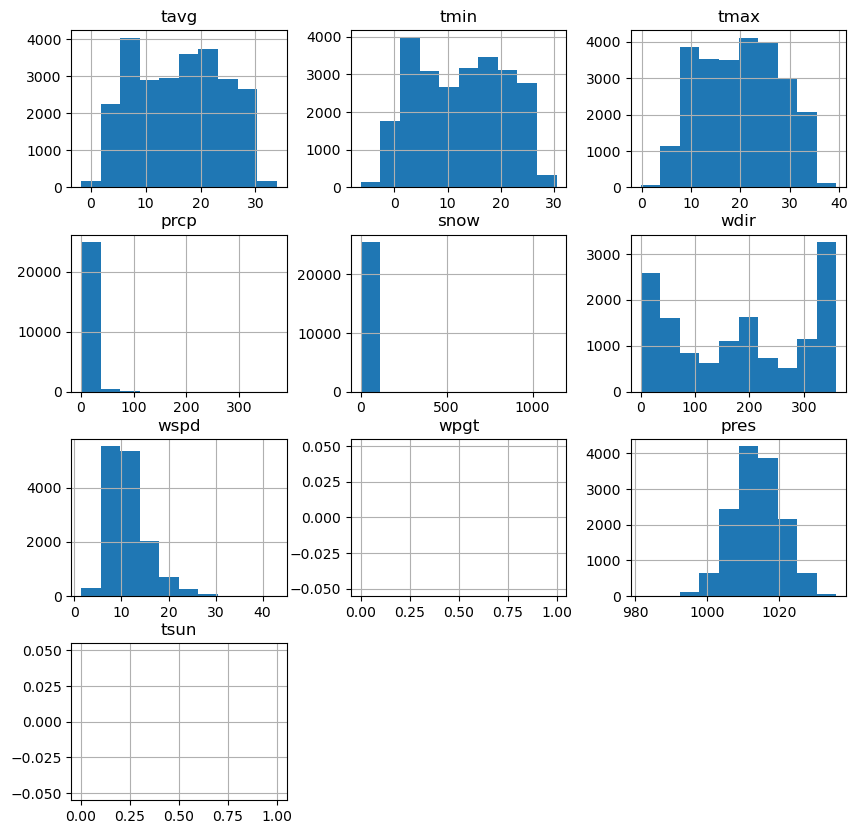

In [28]:
tokyo_daily.hist(figsize=(10, 10))
plt.title("Tokyo Daily Weather Data from 1952 to 2023")
plt.show()

In [23]:
weather_df["Site Name"].unique()

array(['Wakkanai', 'Rumoi', 'Asahikawa', 'Abashiri', 'Sapporo',
       'Iwamizawa', 'Obihiro', 'Kushiro', 'Nemuro', 'Muroran', 'Urakawa',
       'Esashi', 'Hakodate', 'Kutchan', 'Monbetsu', 'Hiroo', 'Shinjo',
       'Aomori', 'Hachinohe', 'Akita', 'Morioka', 'Miyako', 'Sakata',
       'Yamagata', 'Sendai', 'Fukushima', 'Shirakawa', 'Onahama',
       'Wajima', 'Aikawa', 'Niigata', 'Kanazawa', 'Toyama', 'Nagano',
       'Takada', 'Utsunomiya', 'Fukui', 'Takayama', 'Matsumoto',
       'Maebashi', 'Kumagaya', 'Mito', 'Tsuruga', 'Gifu', 'Nagoya',
       'Iida', 'Kofu', 'Choshi', 'Tsu', 'Hamamatsu', 'Shizuoka',
       'Tokyo Japan', 'Owashi', 'Yokohama', 'Tateyama', 'Oshima',
       'Miyakejima', 'Hachijojima', 'Saigo', 'Matsue', 'Yonago',
       'Tottori', 'Toyooka', 'Maizuru', 'Hamada', 'Kyoto', 'Hikone',
       'Hiroshima', 'Okayama', 'Kobe', 'Osaka', 'Sumoto', 'Wakayama',
       'Nara', 'Matsuyama', 'Takamatsu', 'Uwajima', 'Kochi', 'Tokushima',
       'Shimonoseki', 'Fukuoka', 'Saga', 'O

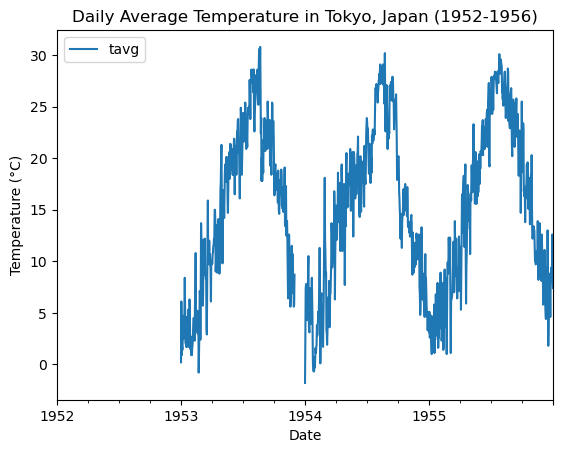

In [34]:
tokyo_data = weather_df[
    (weather_df["Site Name"] == "Tokyo Japan")
    & (weather_df["time"] >= datetime(1952, 1, 1))
    & (weather_df["time"] < datetime(1956, 1, 1))
]
tokyo_data.plot(x="time", y="tavg")
plt.title("Daily Average Temperature in Tokyo, Japan (1952-1956)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Fetch Historical Weather Data with Meteostat #

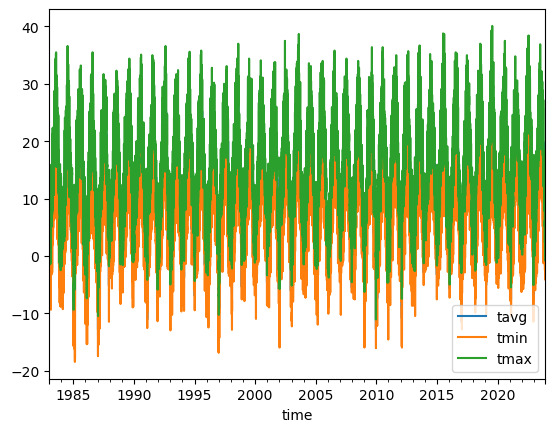

In [16]:
# Set time period
start = datetime(1983, 1, 1)
end = datetime(2023, 12, 4)

# Get daily data
data = Daily("10637", start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()